# Deep learning for hyperspectral image processing: 3-D convolutional neural networks
This notebook demonstrates application of 3-Dimensional Convolutional Neural Network (3-D CNN) models to land use classification. Two separate notebooks are also available, describing application of 2-Dimensional Convolutional neural network [(2-D CNN)](deep_learning_2D_CNN.ipynb) as well as Multi-Layer Perceptron [(MLP)](deep_learning_MLP.ipynb) models to land use classification using hyperspectral data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Module imports
Below is the list of libraries and modules that are required in this notebook. The 'keras' package provides the building blocks for model configuration and training. The 'img_util' contains a set of useful functions for pre-processing of raw data to create input and output data containers, compatible to the 'keras' package. In addition, it provides a set of functions for post-processing of results and visualization of prediction maps.
The 'sio' and 'os' module are were for working with external files. The plotting of data and generation of prediction maps were achieved using plotting functionalities of 'matplotlib'.  

In [2]:
# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/Walter/RADHESYAM_VADDI_2DCNN')

import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt


## Hyperspectral dataset
A set of publically-available hyperspectral imageray datasets can be downloaded form [this](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) website. The Indian Pine dataset was downloaded and used in this notebook. The dataset consists of 150$\times$150 pixels with 200 refelactance bands. The ground truth data for the dataset consists of 16 different classes. A summary of landuse types and their corresponding number of samples can be found in the following table:

| ID       | Class                        | Samples |
|----------|------------------------------|---------|
| 0        | Unlabeled                    | 10776   |
| 1        | Alfalfa                      | 46      |
| 2        | Corn-notill                  | 1428    |
| 3        | Corn-mintill                 | 830     |
| 4        | Corn                         | 237     |
| 5        | Grass-pasture                | 483     |
| 6        | Grass-trees                  | 730     |
| 7        | Grass-pasture-mowed          | 28      |
| 8        | Hay-windrowed                | 478     |
| 9        | Oats                         | 20      |
| 10       | Soybean-notill               | 972     |
| 11       | Soybean-mintill              | 2455    |
| 12       | Soybean-clean                | 593     |
| 13       | Wheat                        | 205     |
| 14       | Woods                        | 1265    |
| 15       | Buildings-Grass-Trees-Drives | 386     |
| 16       | Stone-Steel-Towers           | 93      |

The image data and class labels are available in two separate Matlab files with .mat extension. Therefore, the data were loaded into Python using the 'loadmat' function, available in the 'io' module of Scipy.

In [3]:
data_folder = './'
data_file= './KSC.mat'
gt_file = './KSC_gt.mat'

# Load the image data from the data file.
data_set = sio.loadmat(os.path.join(data_folder, data_file))['KSC']

# Load the ground truth data from the gt file.
gt = sio.loadmat(os.path.join(data_folder, gt_file))['KSC_gt']

# Check the shape of the data_set and gt arrays.
print(data_set.shape, gt.shape)

(512, 614, 176) (512, 614)


## Training and test data
The 'data_split' function was used for splitting the data into training and test sets using 0.75 as the split ratio (75% of labeled pixels were used for training). This function ensures that all classes are represented in the training dataset (see function documentation for available split methods). In addition, it allows users to focus their analysis on certain classes and remove those pixels that are not labeled. For example, the unlabeled data in the gourd truth data file are represented by 0 . Therefore, 0 was included in 'rem_classes' list, indicating its removal from the dataset.

In [4]:
train_fraction = 0.75
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 3902.
Number of test samples = 1306.


A portion of training data can optionally be set aside for validation.

In [6]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

## Dimensionality reduction
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). Although, this step is not necessary, it could significantly reduce the spectral dimension without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [7]:
data_set = util.reduce_dim(img_data=data_set, n_components=15)
data_set.shape


(512, 614, 15)

Using a value of 0.999 for the percentage of captured variance, the spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

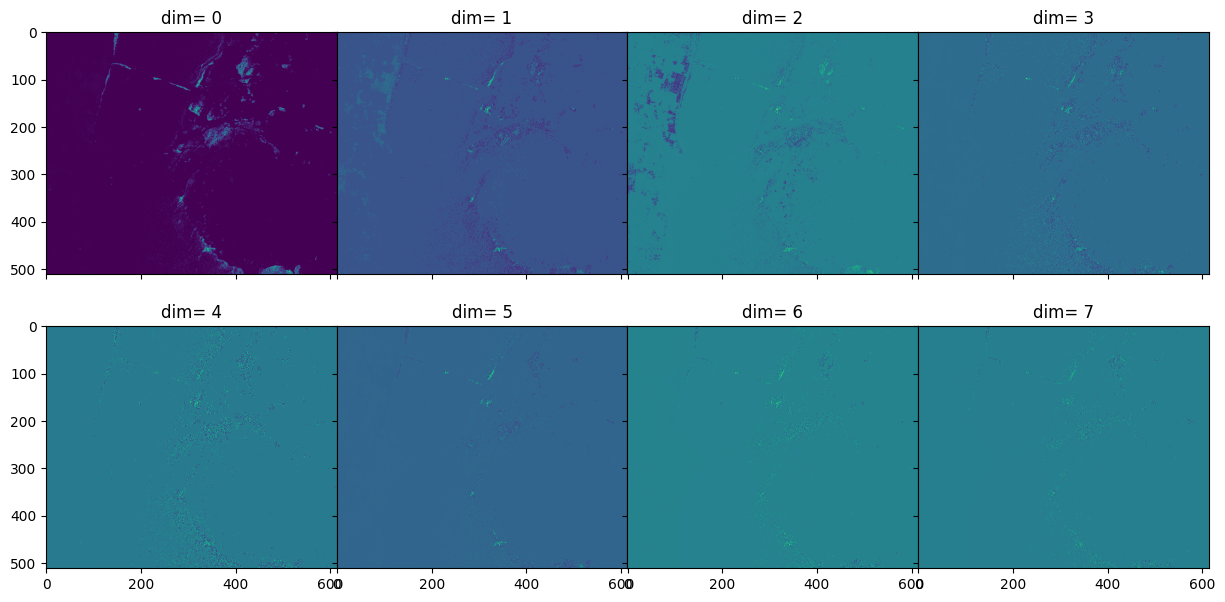

In [8]:
fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(15, 7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(data_set[:, :, numb])
    axe.set_title('dim=' + ' ' + str(numb))

fig.subplots_adjust(wspace=0, hspace=.2)
plt.show()

## Rescaling data
The 'rescale_data' function provides four methods for rescaling data at each spectral dimension. In this notebook, the 'standard' method which transforms the data to have zero mean and a standard deviation of 1 was used for rescaling data.

In [9]:
data_set = util.rescale_data(data_set)

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models.
In this notebook, a 3-D CNN model with a 'path_size' of 9 was used for classification.  

In [10]:
patch_size=9
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols)
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels)

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

print("Train input shape:", train_input_sub.shape)
print("Validation input shape:", val_input.shape)
print("Test input shape:", test_input.shape)

# # Adding a new axis to make the input shape compatible to a 3-D conv network
# train_input_sub, val_input, test_input = np.array([np.expand_dims(elm,-1) for elm
#                                                    in (train_input_sub, val_input, test_input)])

Train input shape: (3701, 9, 9, 15)
Validation input shape: (201, 9, 9, 15)
Test input shape: (1306, 9, 9, 15)


## Creating a 3-D CNN model
The network architecture consists of a 3-D convolutional layer as input layer. The input layer is followed by a maximum pooling layer with a pooling and stride size of (1, 1, 3). The third layer is a 3-D convolutional layer, followed by a maximum pooling layer. The 'zero_pad_3D' function checks if the spectral dimension is a multiple of the stride size, and zero-pad the output of the pooling layer if it is not a multiple of the stride size (see zero_pad_3D' function documentation for more details). The sixth layer is a 3-D convolutional layer whose output is flatten by a subsequent 'flatten' layer. The 'flatten' layer is followed by a 'drop-out' layer with a drop rate of 0.35  and three subsequent 'dense' layers.    

In [12]:
# from keras.models import Sequential
# from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
# from keras import regularizers

# # Define parameters
# kernel_size = (3, 3, 5)  # 3-D convolutional layer kernel size
# pool_size = (1, 1, 3)    # 3-D pooling kernel size
# lr = 1e-3                # learning rate
# l2_parm = 1e-3           # l2 regularization parameter
# batch_size = 32          # batch size for training model
# filters_1 = 64           # Number of filters in the first convolutional layer
# filters_2 = 32           # Number of filters in the second convolutional layer
# filters_3 = 32           # Number of filters in the third convolutional layer
# drop_rate = 0.35         # Dropout rate in the dropout layer
# units_1 = 128            # Number of neurons in the first 'dense' layer
# units_2 = 128            # Number of neurons in the second 'dense' layer

# input_shape = (patch_size, patch_size, data_set.shape[-1], 1)  # Adjusted input shape

# # Building a 3-D Convolutional network model
# cnn_model = Sequential()

# # conv_1
# cnn_model.add(Conv3D(filters=filters_1,
#                      kernel_size=kernel_size,
#                      strides=(1, 1, 1), padding='valid',
#                      kernel_regularizer=regularizers.l2(l2_parm),
#                      input_shape=input_shape))

# # max_pool_1
# # cnn_model.add(MaxPooling3D(pool_size=pool_size,
# #                            strides=pool_size,
# #                            padding='valid'))
# cnn_model.add(MaxPooling3D(pool_size=(1, 1, 1),
#                            strides=(1, 1, 1),
#                            padding='valid'))

# # zero_padding_1
# util.zero_pad_3D(cnn_model)
# cnn_model.add(Conv3D(filters=filters_1,
#                      kernel_size=kernel_size,
#                      strides=(1, 1, 1), padding='valid',
#                      kernel_regularizer=regularizers.l2(l2_parm),
#                      input_shape=input_shape))
# # conv_2
# # cnn_model.add(Conv3D(filters=filters_2,
# #                      kernel_size=kernel_size,
# #                      strides=(1, 1, 1), padding='valid',
# #                      kernel_regularizer=regularizers.l2(l2_parm)))

# # max_pool_2
# cnn_model.add(MaxPooling3D(pool_size=pool_size,
#                            strides=pool_size,
#                            padding='valid'))

# # zero_padding_2
# util.zero_pad_3D(cnn_model)

# # conv_3
# cnn_model.add(Conv3D(filters=filters_1,
#                      kernel_size=kernel_size,
#                      strides=(1, 1, 1), padding='valid',
#                      kernel_regularizer=regularizers.l2(l2_parm)))

# # flatten_1
# cnn_model.add(Flatten())

# # dropout_1
# cnn_model.add(Dropout(drop_rate))

# # dense_1
# cnn_model.add(Dense(units=units_1, activation='relu'))

# # dense_2
# cnn_model.add(Dense(units=units_2, activation='relu'))

# # dense_3 (output_layer)
# cnn_model.add(Dense(units=13, activation='softmax'))

# cnn_model.summary()
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from keras import regularizers

# Define parameters
kernel_size = (3, 3, 5)  # 3-D convolutional layer kernel size
pool_size = (1, 1, 1)    # Adjusted 3-D pooling kernel size
lr = 1e-3                # learning rate
l2_parm = 1e-3           # l2 regularization parameter
batch_size = 32          # batch size for training model
filters_1 = 64           # Number of filters in the first convolutional layer
filters_2 = 32           # Number of filters in the second convolutional layer
filters_3 = 32           # Number of filters in the third convolutional layer
drop_rate = 0.35         # Dropout rate in the dropout layer
units_1 = 128            # Number of neurons in the first 'dense' layer
units_2 = 128            # Number of neurons in the second 'dense' layer

input_shape = (9, 9, 15, 1)  # Adjusted input shape

# Building a 3-D Convolutional network model
cnn_model = Sequential()

# conv_1
cnn_model.add(Conv3D(filters=filters_1,
                     kernel_size=kernel_size,
                     strides=(1, 1, 1),
                     padding='valid',
                     kernel_regularizer=regularizers.l2(l2_parm),
                     input_shape=input_shape))

# max_pool_1
cnn_model.add(MaxPooling3D(pool_size=pool_size,
                           strides=pool_size,
                           padding='valid'))

# conv_2
cnn_model.add(Conv3D(filters=filters_2,
                     kernel_size=kernel_size,
                     strides=(1, 1, 1),
                     padding='valid',
                     kernel_regularizer=regularizers.l2(l2_parm)))

# max_pool_2
cnn_model.add(MaxPooling3D(pool_size=pool_size,
                           strides=pool_size,
                           padding='valid'))

# conv_3
cnn_model.add(Conv3D(filters=filters_3,
                     kernel_size=kernel_size,
                     strides=(1, 1, 1),
                     padding='valid',
                     kernel_regularizer=regularizers.l2(l2_parm)))

# flatten_1
cnn_model.add(Flatten())

# dropout_1
cnn_model.add(Dropout(drop_rate))

# dense_1
cnn_model.add(Dense(units=units_1, activation='relu'))

# dense_2
cnn_model.add(Dense(units=units_2, activation='relu'))

# dense_3 (output_layer)
cnn_model.add(Dense(units=13, activation='softmax'))

cnn_model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 7, 7, 11, 64)   │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 7, 7, 11, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 5, 5, 7, 32)    │        92,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 5, 5, 7, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 3, 3, 3, 32)    │        46,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,157 (1.03 MB)

 Trainable params: 270,157 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors)

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - categorical_accuracy: 0.3138 - loss: 2.1589 - val_categorical_accuracy: 0.5274 - val_loss: 1.3442
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - categorical_accuracy: 0.5363 - loss: 1.3675 - val_categorical_accuracy: 0.5721 - val_loss: 1.1220
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - categorical_accuracy: 0.5779 - loss: 1.2317 - val_categorical_accuracy: 0.5871 - val_loss: 1.0339
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - categorical_accuracy: 0.6006 - loss: 1.1338 - val_categorical_accuracy: 0.6070 - val_loss: 0.9940
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - categorical_accuracy: 0.6383 - loss: 1.0222 - val_categorical_accuracy: 0.5821 - val_loss: 1.3261
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - categorical_accuracy: 0.6284 - loss: 1.1310 - val_categorical_accuracy: 0.6418 - val_loss: 1.0083
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - categorical_accuracy: 0.682

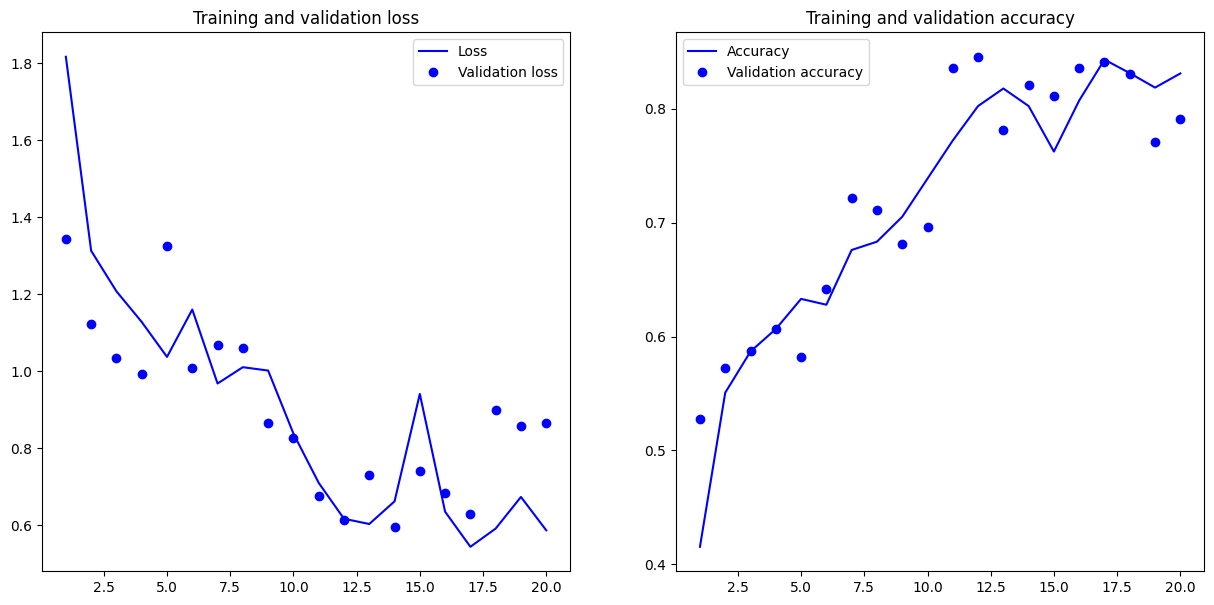

In [13]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
# Training the model
# Train the model using the loaded data
history = cnn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                        epochs=20, validation_data=(val_input, y_val), verbose=True)


epoches = np.arange(1,len(history.history.get('loss'))+1)
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15,7))
ax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')
ax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.legend()
ax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')
ax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.legend()
plt.show()



## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [14]:
overall_loss, overal_accu = cnn_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
model_metrics = util.calc_metrics(cnn_model, test_input,
                                           y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.7747159600257874
Overall accuracy = 0.7649310827255249

Class ID     Accuracy
______________________________
 1            0.5026
______________________________
 2            0.8852
______________________________
 3            0.6875
______________________________
 4            0.3492
______________________________
 5            0.4146
______________________________
 6            0.6379
______________________________
 7            0.8846
______________________________
 8            0.7407
______________________________
 9            0.8462
______________________________
10            0.7624
______________________________
11            0.9714
______________________________
12            0.8651
______________________________
13            0.9828
______________________________


In [19]:
cnn_model.save('3D_KSC_HSI.h5')

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
Y_pred = cnn_model.predict(train_input_sub)
y_pred = np.argmax(Y_pred, axis=1)
kappa = cohen_kappa_score(np.argmax(y_train_sub, axis=1), y_pred)
kappa

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


0.7815103360173428

## Making predictions using using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels.

5208/5208 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (314368,) + inhomogeneous part.

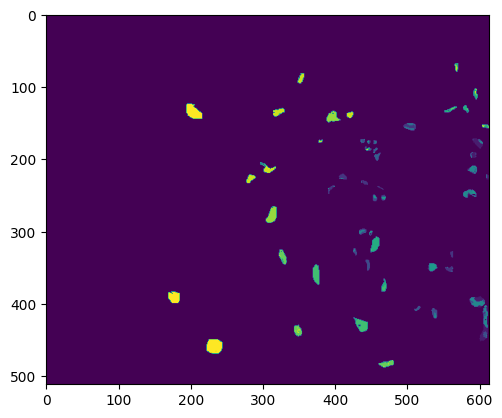

In [22]:
# Plotting predicted results
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(cnn_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
plt.imshow(partial_map)
# full_map = util.plot_full_map(cnn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)

# fig, (ax1, ax2) = plt.subplots(1,2,True, True, figsize=(15,7))
# ax1.imshow(partial_map)
# ax1.set_title('Prediction map for labeled data', fontweight="bold", fontsize='14')
# ax2.imshow(full_map)
# ax2.set_title('Prediction map for all data', fontweight="bold", fontsize='14')
plt.show()

As indicated, the salt-and-pepper noise resulting from classification using the [MLP model](deep_learning_MLP.ipynb) is not present in the CNN model predictions.

See also:
### [Deep learning for hyperspectral image processing: Multi-layer perceptron networks](deep_learning_MLP.ipynb)
### [Deep learning for hyperspectral image processing: 2-D convolutional neural networks](deep_learning_2D_CNN.ipynb)
### [Deep learning for hyperspectral image processing: 3-D convolutional neural networks](deep_learning_3D_CNN.ipynb)

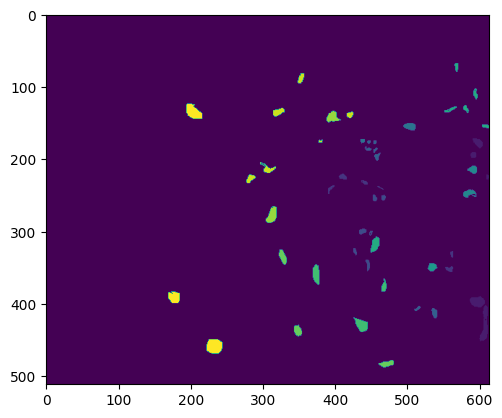

In [17]:
plt.imshow(gt)